In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy/Energy_consumption_India_2.csv')
df.head()

,States,Regions,latitude,longitude,Dates,Usage
0,Punjab,NR,31.519974,75.980003,02/01/2019 00:00:00,119.9
1,Haryana,NR,28.450006,77.019991,02/01/2019 00:00:00,130.3
2,Rajasthan,NR,26.449999,74.639981,02/01/2019 00:00:00,234.1
3,Delhi,NR,28.669993,77.230004,02/01/2019 00:00:00,85.8
4,UP,NR,27.599981,78.050006,02/01/2019 00:00:00,313.9


In [4]:
df.tail()

,States,Regions,latitude,longitude,Dates,Usage
16594,Manipur,NER,24.799971,93.950017,05/12/2020 00:00:00,2.5
16595,Meghalaya,NER,25.570492,91.880014,05/12/2020 00:00:00,5.8
16596,Mizoram,NER,23.710399,92.720015,05/12/2020 00:00:00,1.6
16597,Nagaland,NER,25.666998,94.116570,05/12/2020 00:00:00,2.1
16598,Tripura,NER,23.835404,91.279999,05/12/2020 00:00:00,3.3


In [5]:
df.shape

(16599, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16599 entries, 0 to 16598
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   States     16599 non-null  object 
 1   Regions    16599 non-null  object 
 2   latitude   16599 non-null  float64
 3   longitude  16599 non-null  float64
 4   Dates      16599 non-null  object 
 5   Usage      16599 non-null  float64
dtypes: float64(3), object(3)
memory usage: 778.2+ KB


In [7]:
df.isnull().sum()

States       0
Regions      0
latitude     0
longitude    0
Dates        0
Usage        0
dtype: int64

In [8]:
df['date'] = pd.to_datetime(df['Dates'])

In [9]:
plt.rcParams['figure.figsize'] = [15,8]

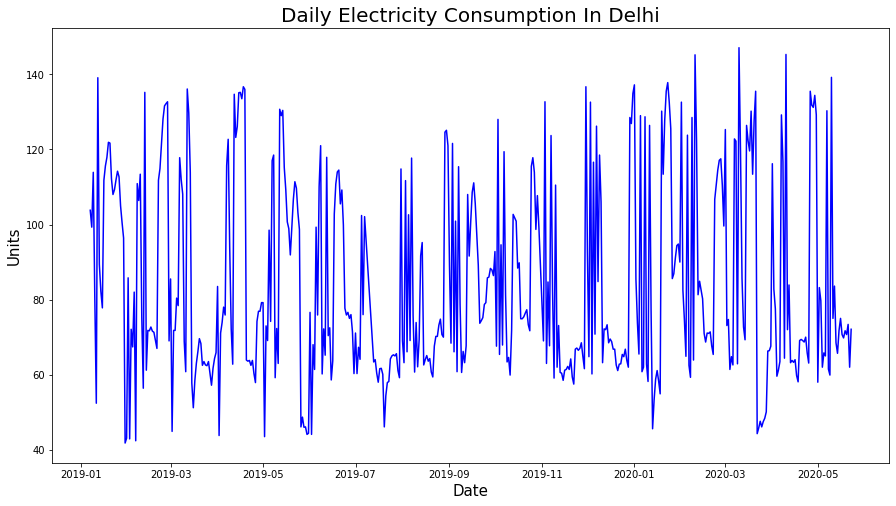

In [10]:
df_del = df[df['States'] == 'Delhi']
df_del_grp = df_del.groupby('date').agg({'Usage':'sum'})
plt.plot(df_del_grp,color='blue',linewidth=1.5)
plt.title('Daily Electricity Consumption In Delhi',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [11]:
len(df_del_grp)

498

In [12]:
time = pd.date_range(start='1/7/2019',periods=498,freq='D')

In [13]:
df_del_grp.set_index(time,inplace=True)

In [14]:
df_del_grp

,Usage
2019-01-07,103.8
2019-01-08,99.3
2019-01-09,113.9
2019-01-10,80.7
2019-01-11,52.4
...,...
2020-05-14,71.7
2020-05-15,70.7
2020-05-16,73.4
2020-05-17,62.0


In [15]:
df = df_del_grp.copy()

In [16]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [17]:
#Split data set into testing dataset and train dataset
train_size = 450
train, test =df.values[0:train_size,:],df.values[train_size:len(df.values),:]
# setup look_back window 
look_back = 6
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(444, 1, 6)
(444,)
(42, 1, 6)
(42,)


In [19]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.3 MB/s 


In [21]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [22]:
def build_model(hp):
    model = keras.Sequential()
    model.add(SimpleRNN(hp.Int('first_rnn_layer',min_value=8,max_value=128,step=8), activation="relu",return_sequences=True, input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(SimpleRNN(hp.Int(f'rnn_{i}_units',min_value=8,max_value=128,step=8),activation="relu", return_sequences=True,recurrent_dropout = hp.Choice(f"recurrent_dropout_{i}",[0.2,0.4,0.6],default=0.4)))
    model.add(SimpleRNN(hp.Int('final_rnn_layer',min_value=8,max_value=128,step=8),activation="relu",recurrent_dropout = hp.Choice("last_recurrent_dropout",[0.2,0.4,0.6],default=0.4) ))
    model.add(Dense(hp.Int('dense_layer_1',min_value=8,max_value=128,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [23]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=2,
    directory='project',
    project_name='del_consum')

In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 10
first_rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
rnn_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
recurrent_dropout_0 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
final_rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
last_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'defau

In [25]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=32,
             validation_data=(testX, testY))

Trial 20 Complete [00h 01m 11s]
val_mape: 14.916617393493652

Best val_mape So Far: 13.017337799072266
Total elapsed time: 00h 26m 00s
INFO:tensorflow:Oracle triggered exit


In [26]:
tuner.results_summary()

Results summary
Results in project/del_consum
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
first_rnn_layer: 64
first_recurrent_dropout: 0.6
n_layers: 2
rnn_0_units: 88
recurrent_dropout_0: 0.4
final_rnn_layer: 16
last_recurrent_dropout: 0.4
dense_layer_1: 56
Dropout_rate: 0.30000000000000004
learning_rate: 0.022575118658899683
rnn_1_units: 104
recurrent_dropout_1: 0.4
Score: 13.017337799072266
Trial summary
Hyperparameters:
first_rnn_layer: 88
first_recurrent_dropout: 0.2
n_layers: 1
rnn_0_units: 72
recurrent_dropout_0: 0.6
final_rnn_layer: 24
last_recurrent_dropout: 0.4
dense_layer_1: 104
Dropout_rate: 0.2
learning_rate: 0.02652391033661071
rnn_1_units: 8
recurrent_dropout_1: 0.2
rnn_2_units: 16
recurrent_dropout_2: 0.4
rnn_3_units: 80
recurrent_dropout_3: 0.6
Score: 13.252918720245361
Trial summary
Hyperparameters:
first_rnn_layer: 112
first_recurrent_dropout: 0.2
n_layers: 2
rnn_0_units: 64
recurrent_dropout_0: 0.6
final_rnn_layer

In [27]:
from warnings import filterwarnings
filterwarnings('ignore')

In [28]:
models = tuner.get_best_models(num_models=2)
best_model = models[1]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 6))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 88)             8360      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1, 72)             11592     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 24)                2328      
                                                                 
 dense (Dense)               (None, 104)               2600      
                                                                 
 dropout (Dropout)           (None, 104)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 105       
                                                                 
Total params: 24,985
Trainable params: 24,985
Non-traina

In [29]:
from tensorflow.keras import optimizers

In [54]:
model = Sequential()
model.add(SimpleRNN(32,activation='relu',input_shape=(1,look_back), return_sequences=True, recurrent_dropout = 0.2))
model.add(SimpleRNN(16,activation='relu',recurrent_dropout = 0.4))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.0002652391033661071)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX, testY), batch_size = 32, epochs = 300)

Epoch 1/300
14/14 [==============================] - 5s 82ms/step - loss: 107.8724 - mape: 107.8724 - val_loss: 101.1478 - val_mape: 101.1478
Epoch 2/300
14/14 [==============================] - 0s 4ms/step - loss: 94.9969 - mape: 94.9969 - val_loss: 89.2915 - val_mape: 89.2915
Epoch 3/300
14/14 [==============================] - 0s 5ms/step - loss: 83.2584 - mape: 83.2584 - val_loss: 77.4085 - val_mape: 77.4085
Epoch 4/300
14/14 [==============================] - 0s 5ms/step - loss: 72.2708 - mape: 72.2708 - val_loss: 64.6687 - val_mape: 64.6687
Epoch 5/300
14/14 [==============================] - 0s 5ms/step - loss: 59.6710 - mape: 59.6710 - val_loss: 51.4780 - val_mape: 51.4780
Epoch 6/300
14/14 [==============================] - 0s 5ms/step - loss: 47.1563 - mape: 47.1563 - val_loss: 38.1163 - val_mape: 38.1163
Epoch 7/300
14/14 [==============================] - 0s 5ms/step - loss: 37.8503 - mape: 37.8503 - val_loss: 27.2707 - val_mape: 27.2707
Epoch 8/300
14/14 [=================

In [55]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train MAPE : 17.50
Test MAPE : 15.25


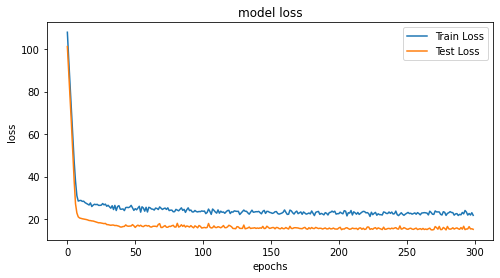

In [56]:
train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train MAPE : %.2f'% (train_score[1]))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test MAPE : %.2f'% (test_score[1]))
model_loss(model_history)

In [57]:
import seaborn as sns

In [58]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(444,486)]
    plt.figure(figsize=(15,8))
    plt.plot(trainY)
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

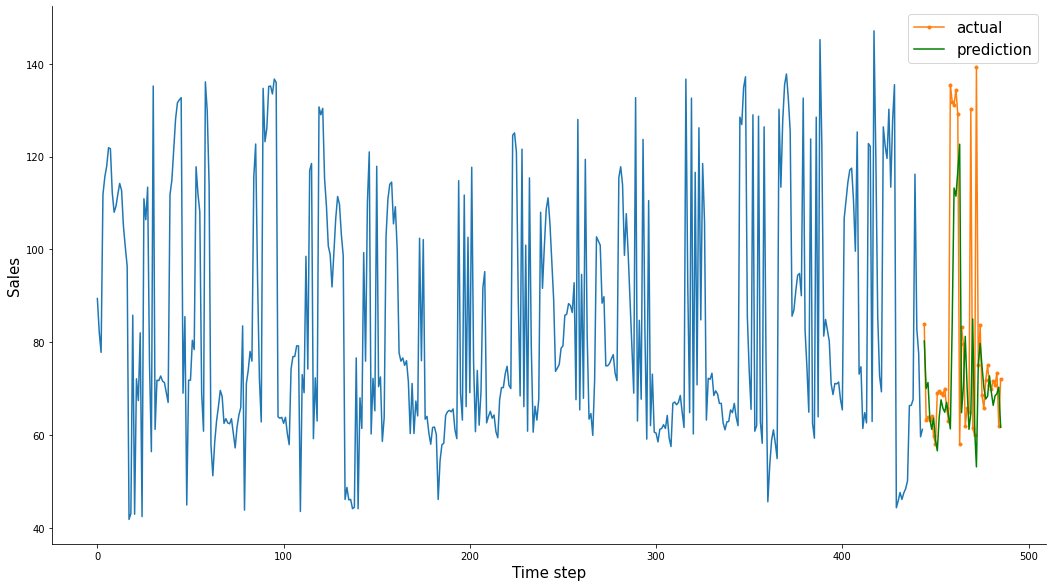

In [59]:
test_predict = model.predict(testX)
prediction_plot(testY, test_predict)